### Walkthrough of building a recommender system
We are going to use the movielens to build a simple item similarity based recommender system. The first thing we need to do is to import pandas and numpy.

### Item based collaborative filtering

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Next we load in the data set using pandas read_csv() utility. The dataset is tab separated so we pass in \t to the sep parameter. We then pass in the column names using the names parameter.

In [4]:
df = pd.read_csv('u.data', sep='\t', names=['user_id','item_id','rating','titmestamp'])

In [5]:
df.head()

,user_id,item_id,rating,titmestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596




It would be nice if we can see the titles of the movie instead of just dealing with the IDs. Let’s load in the movie titles and merge it with this dataset.

In [13]:
movie_titles = pd.read_csv('movies.csv')

movie_titles.rename(columns={'movieId':'item_id'},inplace=True)
movie_titles.head()

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy




>  Since the item_id columns are the same we can merge these datasets on this column.


In [14]:
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,titmestamp,title,genres
0,196,242,3,881250949,Farinelli: il castrato (1994),Drama|Musical
1,63,242,3,875747190,Farinelli: il castrato (1994),Drama|Musical
2,226,242,5,883888671,Farinelli: il castrato (1994),Drama|Musical
3,154,242,3,879138235,Farinelli: il castrato (1994),Drama|Musical
4,306,242,5,876503793,Farinelli: il castrato (1994),Drama|Musical


In [15]:
df.describe()

,user_id,item_id,rating,titmestamp
count,98679.000000,98679.000000,98679.000000,9.867900e+04
mean,462.404230,422.052514,3.534491,8.835204e+08
std,266.657807,328.175042,1.124545,5.344992e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,174.000000,3.000000,8.794481e+08
50%,447.000000,318.000000,4.000000,8.828258e+08
75%,682.000000,627.000000,4.000000,8.882068e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


We can tell that the average rating is 3.52 and the max is 5. 

We also see that the dataset has 100003 records.

Let’s now create a dataframe with the average rating for each movie and the number of ratings. We are going to use these ratings to calculate the correlation between the movies later. Correlation is a statistical measure that indicates the extent to which two or more variables fluctuate together. Movies that have a high correlation coefficient are the movies that are most similar to each other. In our case we shall use the Pearson correlation coefficient. This number will lie between -1 and 1. 1 indicates a positive linear correlation while -1 indicates a negative correlation. 0 indicates no linear correlation. Therefore movies with a zero correlation are not similar at all. In order to create this dataframe we use pandas groupby functionality. We group the dataset by the title column and compute its mean to obtain the average rating for each movie.

In [16]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.548387
1-900 (06) (1994),3.384615
101 Dalmatians (1996),4.200000
12 Angry Men (1957),4.047619
187 (One Eight Seven) (1997),1.666667


Next we would like to see the number of ratings for each movie. We do this by creating a number_of_ratings column. This is important so that we can see the relationship between the average rating of a movie and the number of ratings the movie got. It is very possible that a 5 star movie was rated by just one person. It is therefore statistically incorrect to classify that movie has a 5 star movie. We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system. In order to create this new column we use pandas groupby utility. We group by the title column and then use the count function to calculate the number of ratings each movie got. Afterwards we view the new dataframe by using the head() function.

In [17]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.head()

,rating,number_of_ratings
title,,
'Til There Was You (1997),2.548387,31
1-900 (06) (1994),3.384615,13
101 Dalmatians (1996),4.200000,5
12 Angry Men (1957),4.047619,21
187 (One Eight Seven) (1997),1.666667,3


Let’s now plot a Histogram using pandas plotting functionality to visualize the distribution of the ratings

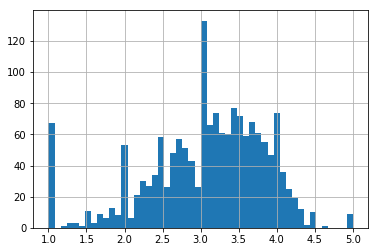

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)
plt.show()

We can see that most of the movies are rated between 2.5 and 4. Next let’s visualize the number_of_ratings column in as similar manner.

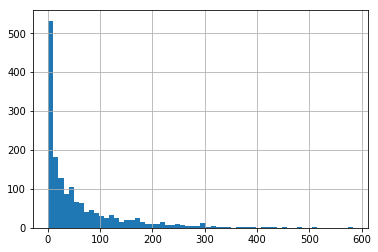

In [22]:
ratings['number_of_ratings'].hist(bins=60)
plt.show()

Let’s now check the relationship between the rating of a movie and the number of ratings.
We do this by plotting a scatter plot using seaborn. Seaborn enables us to do this using the jointplot() function.


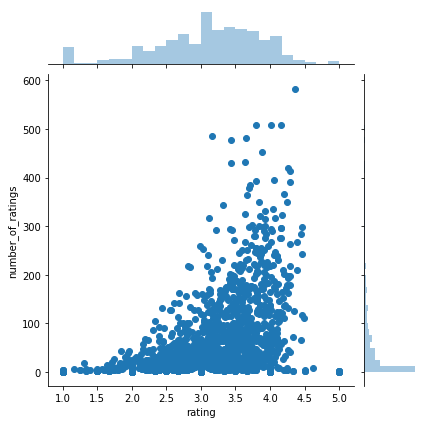

In [26]:
import seaborn as sns

sns.jointplot(x='rating', y='number_of_ratings', data=ratings)
plt.show()

From the diagram we can see that their is a positive relationship between the average rating of a movie and the number of ratings. The graph indicates that the more the ratings a movie gets the higher the average rating it gets. This is important to note especially when choosing the threshold for the number of ratings per movie.

Let’s now move on swiftly and create a simple item based recommender system. In order to do this we need to convert our dataset into a matrix with the movie titles as the columns, the user_id as the index and the ratings as the values. By doing this we shall get a dataframe with the columns as the movie titles and the rows as the user ids. Each column represents all the ratings of a movie by all users. The rating appear as NAN where a user didn't rate a certain movie. We shall use this matrix to compute the correlation between the ratings of a single movie and the rest of the movies in the matrix. We use pandas pivot_table utility to create the movie matrix.

In [27]:
movie_matrix = df.pivot_table(index='user_id', columns='title', values='rating')
movie_matrix.head()

title,'Til There Was You (1997),1-900 (06) (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"301, 302 (301/302) (1995)",...,Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),"Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)",Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next let’s look at the most rated movies and choose two of them to work with in this simple recommender system. We use pandas sort_values utility and set ascending to false in order to arrange the movies from the most rated. We then use the head() function to view the top 10.

In [28]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
"Usual Suspects, The (1995)",4.358491,583
"Kid in King Arthur's Court, A (1995)",3.803536,509
City Hall (1996),4.155512,508
Mighty Morphin Power Rangers: The Movie (1995),4.007890,507
"Perez Family, The (1995)",3.156701,485
Nemesis 2: Nebula (1995),3.656965,481
Natural Born Killers (1994),3.441423,478
Toy Story (1995),3.878319,452
Quiz Show (1994),3.631090,431


Let’s assume that a user has watched Mighty Morphin Power Rangers: The Movie (1995) and Toy Story (1995). We would like like to recommend movies to this user based on this watching history. The goal is to look for movies that are similar to  Toy Story (1995)and Mighty Morphin Power Rangers: The Movie (1995) which we shall recommend to this user. We can achieve this by computing the correlation between these two movies’ ratings and the ratings of the rest of the movies in the dataset. The first step is to create a dataframe with the ratings of these movies from our movie_matrix.

In [46]:
Toy_user_rating = movie_matrix['Toy Story (1995)']
power_user_rating = movie_matrix['Mighty Morphin Power Rangers: The Movie (1995)']

In [44]:
print(Toy_user_rating.head())

print(power_user_rating.head())

user_id
1    5.0
2    4.0
3    NaN
4    NaN
5    4.0
Name: Toy Story (1995), dtype: float64
user_id
1    5.0
2    NaN
3    4.0
4    NaN
5    5.0
Name: Mighty Morphin Power Rangers: The Movie (1995), dtype: float64


In order to compute the correlation between two dataframes we use pandas corwith functionality. Corrwith computes the pairwise correlation of rows or columns of two dataframe objects. Let's use this functionality to get the correlation between each movie's rating and the ratings of the Toy story movie.

In [45]:
similar_to_toy_story=movie_matrix.corrwith(Toy_user_rating)

similar_to_toy_story.head()

title
'Til There Was You (1997)       0.128415
1-900 (06) (1994)               0.686406
101 Dalmatians (1996)                NaN
12 Angry Men (1957)            -0.036084
187 (One Eight Seven) (1997)         NaN
dtype: float64

We can see that the correlation between TOy story movie and 1-900 (06) is 0.687. This indicates a very strong similarity between these two movies.

In [47]:
similar_to_power = movie_matrix.corrwith(power_user_rating)

similar_to_power.head()

title
'Til There Was You (1997)       0.06394
1-900 (06) (1994)               0.00000
101 Dalmatians (1996)               NaN
12 Angry Men (1957)             0.01614
187 (One Eight Seven) (1997)    1.00000
dtype: float64

As noticed earlier our matrix had very many missing values since not all the movies were rated by all the users. We therefore drop those null values and transform correlation results into dataframes to make the results look more appealing.

In [53]:
corr_top= pd.DataFrame(similar_to_toy_story, columns=['correlation'])
corr_top.dropna(inplace=True)
print(corr_top.head())
corr_power = pd.DataFrame(similar_to_power, columns=['correlation'])
corr_power.dropna(inplace=True)
print(corr_power.head())

                                                    correlation
title                                                          
'Til There Was You (1997)                              0.128415
1-900 (06) (1994)                                      0.686406
12 Angry Men (1957)                                   -0.036084
2 Days in the Valley (1996)                            0.440959
2 ou 3 choses que je sais d'elle (2 or 3 Things...     0.447914
                              correlation
title                                    
'Til There Was You (1997)        0.063940
1-900 (06) (1994)                0.000000
12 Angry Men (1957)              0.016140
187 (One Eight Seven) (1997)     1.000000
2 Days in the Valley (1996)     -0.160644


In [54]:
corr_top = corr_top.join(ratings['number_of_ratings'])
corr_power = corr_power.join(ratings['number_of_ratings'])
print(corr_top.head())
corr_power.head()

,correlation,number_of_ratings
title,,
'Til There Was You (1997),0.063940,31
1-900 (06) (1994),0.000000,13
12 Angry Men (1957),0.016140,21
187 (One Eight Seven) (1997),1.000000,3
2 Days in the Valley (1996),-0.160644,10


We shall now obtain the movies that are most similar to Toy Story by limiting them to movies that have at least 100 reviews. We then sort them by the correlation column and view the first 10.


In [55]:


corr_top[corr_top['number_of_ratings'] > 100].sort_values(by='correlation', ascending=False).head(10)

,correlation,number_of_ratings
title,,
Toy Story (1995),1.000000,452
Rebecca (1940),0.549100,104
All About Eve (1950),0.457995,101
Speechless (1994),0.456291,101
To Live (Huozhe) (1994),0.454756,175
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),0.449915,124
Aladdin (1992),0.442960,202
Kicking and Screaming (1995),0.432855,129
Being Human (1993),0.428372,129


In [57]:
corr_power[corr_power['number_of_ratings'] > 100].sort_values(by='correlation', ascending=False).head(10)

,correlation,number_of_ratings
title,,
Mighty Morphin Power Rangers: The Movie (1995),1.000000,507
Johnny Mnemonic (1995),0.721229,367
"Usual Suspects, The (1995)",0.672556,583
Jury Duty (1995),0.467391,420
Wild Bill (1995),0.422294,331
"Goofy Movie, A (1995)",0.412559,150
Under Siege 2: Dark Territory (1995),0.411901,350
Chungking Express (Chung Hing sam lam) (1994),0.391322,115
"Man of No Importance, A (1994)",0.364536,208


### MODEL-BASED RECOMMENDER SYSTEMS


These models use models built on user ratings to make the recommendations. This approach offers speed and scalability, unlike classification based models where you have to go back and look into an entire dataset to make final predictions. The algorithm here uses Singular Vector Decomposition(SVD) and Utility matrix ( User item matrix). Utility Matix – These matrices contain data about ratings given by each user for each item. As all customers do not review each product, these matrices are mostly sparse.

In [59]:
movie_matrix.head()

title,'Til There Was You (1997),1-900 (06) (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"301, 302 (301/302) (1995)",...,Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),"Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)",Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
